<a href="https://colab.research.google.com/github/AntonioVidigal/Data_Science/blob/main/REC_INF_WEB_RED_Trilha_7_Antonio_Heldo_Vidigal_Machado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blibliotecas & Downloads


In [ ]:
import os
from google.colab import drive
#drive.mount('/content/drive')

import shutil
import requests

import pandas as pd
import math

import networkx as nx
import matplotlib.pyplot as plt

import imageio


# Monta arquivo para trabalho

### Dados de aeroporto

In [ ]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
	               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
	                        names = airport_col, index_col = 0)
airport_df.head(2)

Name    City  ...     type       source
ID                          ...                      
1   Goroka Airport  Goroka  ...  airport  OurAirports
2   Madang Airport  Madang  ...  airport  OurAirports

[2 rows x 13 columns]

## Dados das rotas

### Arquivo com geolocalizacao

In [ ]:
def monta_pos(IATA):
  airport_pos_df = airport_df.loc[airport_df['IATA'].isin(IATA)][['IATA', 'Lat', 'Long']]
  airport_pos_df.reset_index(inplace=True)
  
  pos = {}
  for index, elem in enumerate (airport_pos_df['IATA']):    
    pos[elem] =  (airport_pos_df.loc[index ,'Long'], airport_pos_df.loc[index ,'Lat']) 

  found = len(airport_pos_df.loc[~airport_pos_df['Lat'].isnull()])
  print(f'{found} Aeroportos com Lat, Long')  

  return pos
  

### Monta topo de rotas, e prepara a lista de aeroportos

In [ ]:
def routes_top(routes_grouped_df, top):
  routes_grouped_df_top = routes_grouped_df.loc[routes_grouped_df['counts'] > top]  

  IATA_dest = set(routes_grouped_df_top['IATA_dest'].unique())
  print(f'{len(IATA_dest)} Aeroportos encontrados destinos')

  IATA_orig = set(routes_grouped_df_top['IATA_orig'].unique())  
  print(f'{len(IATA_orig)} Aeroportos encontrados origem')

  IATA = IATA_dest.union(IATA_orig)
  print(f'{len(IATA)} Aeroportos encontrados total')
  return IATA, routes_grouped_df_top

### Função principal de montagem de rotas

In [ ]:
def monta_rotas(ano, top):
  ######################################################
  # Define nomes mais faceis de manipular para a tabela
  ######################################################
  '''
  0 'ICAO Empresa Aérea'	'Número Voo'	'Código Autorização (DI)'	'Código Tipo Linha'	'ICAO Aeródromo Origem'	'ICAO Aeródromoo Destino'	
  'Partida Prevista'	'Partida Real'	'Chegada Prevista'	'Chegada Real'	
  'Situação Voo'	'Código Justificativa'	'ano'	'mes'                 
  '''

  routes_col = ['company_id', 'flight_no', 'auth_code', 'line_code','ICAO_orig', 'ICAO_dest', 
                'depature_estimated', 'depature_time', 'arrival_estimated', 'arriaval_time', 
                'flight_status', 'flight_status_cause_code', 'ano', 'mes']

  #Carrega a lista do ano, porém eliminando os voos cancelados
  # routes_df = pd.read_csv(f"/content/drive/MyDrive/VRA/VRA_ANO_{ano}.csv"
  #                           ,header=0 ,names = routes_col, index_col = 0) #
  routes_df = pd.read_csv(f"https://github.com/lucianomcsilva/VRA/blob/main/VRA_ANO_2018.csv.zip?raw=true"
                            ,compression='zip' ,header=0 ,names = routes_col, index_col = 0) #

  routes_df = routes_df.loc[routes_df['flight_status'] != 'CANCELADO']

  #Agrupa, mantendo so o que entrara no grafo
  routes_grouped_df = routes_df.groupby(['ICAO_orig', 'ICAO_dest']).size().reset_index(name='counts')                          
  
  ######################################################################
  #Jaz a junção com o Airport.dat para trocar para o codigo de 3 letras
  ######################################################################
  #Join origem
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_orig', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA', 'Country', 'ICAO_dest', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_orig', 'Country': 'Country_orig'}, inplace = True)
  #Join Destino
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_dest', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'Country_orig', 'IATA', 'Country', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_dest', 'Country': 'Country_dest'}, inplace = True)

  #Filtra somente Brazil, e mantem somente as colunas necessarias
  routes_grouped_df = (routes_grouped_df
                        .loc[routes_grouped_df['Country_orig'] == 'Brazil']
                        .loc[routes_grouped_df['Country_dest'] == 'Brazil']
                        .loc[routes_grouped_df['IATA_orig'] != routes_grouped_df['IATA_dest']]
                        .loc[routes_grouped_df['IATA_orig'].str.len() == 3]
                        .loc[routes_grouped_df['IATA_dest'].str.len() == 3]
                        .sort_values(by=['counts'], ascending=False)
                      )
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'IATA_dest', 'counts']]  
  
  #prepara os DataFrames que serão utilizados
  IATA, routes_grouped_df_top = routes_top(routes_grouped_df, top)
  pos = monta_pos(IATA)
  return routes_grouped_df_top, pos

  #lista de aeroportos nao encontrados
  #routes_grouped_df.loc[routes_grouped_df['ICAO'].isnull()]['ICAO_orig'].to_list()
  #df_anac_2015 = pd.read_csv(f"VRA_ANO_2015.csv")


# Grafos

## monta o grafo

In [ ]:
def desenha_grafo2(ano, type='Map'):
  G = nx.Graph()
  pos = {}
  airport_brasil_df = airport_df.loc[airport_df['Country'] == 'Brazil'].loc[airport_df['IATA'].str.len() == 3]
  airport_brasil_df.reset_index(inplace=True)

  for index, elem in enumerate(airport_brasil_df['IATA']):
    #G.add_node(airport_brasil_df.loc[index, 'IATA'])
    pos[elem] =  (airport_brasil_df.loc[index ,'Long'], airport_brasil_df.loc[index ,'Lat']) 
  
  #ignorar pos, ja adicionei todos os aeroportos
  routes, pos_ignore = monta_rotas(ano, 1)
  routes.reset_index(inplace=True)
  for index, elem in enumerate(routes['IATA_orig']):
    G.add_edge(routes.loc[index, 'IATA_orig'], routes.loc[index, 'IATA_dest'])

  options = {
      "font_size": 36,
      "node_size": 7000,
      "node_color": "#336699CC",
      "edgecolors": "#002060",
      "edge_color": "#D34817",
      "linewidths": 5,
      "width": [1+int(math.log(x, 30)) for x in routes['counts'].to_list()],
      "with_labels": True
  }

  plt.figure(figsize = (100,100))
  if type == 'Map':
    nx.draw_networkx(G, pos, **options)
    plt.savefig(f'brasil_2_map_{ano}.png', dpi=50)
  elif type == 'Random':
    nx.draw_random(G, **options)
    plt.savefig(f'brasil_2__random_{ano}.png', dpi=50)    
  elif type == 'Best':
    nx.draw(G, **options)
    plt.savefig(f'brasil_2_best_{ano}.png', dpi=50)        
  else:
    nx.draw_shell(G, **options)
    plt.savefig(f'brasil_2_shell_{ano}.png', dpi=50)

  return G
  #G.add_node(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


117 Aeroportos encontrados destinos
116 Aeroportos encontrados origem
118 Aeroportos encontrados total
118 Aeroportos com Lat, Long


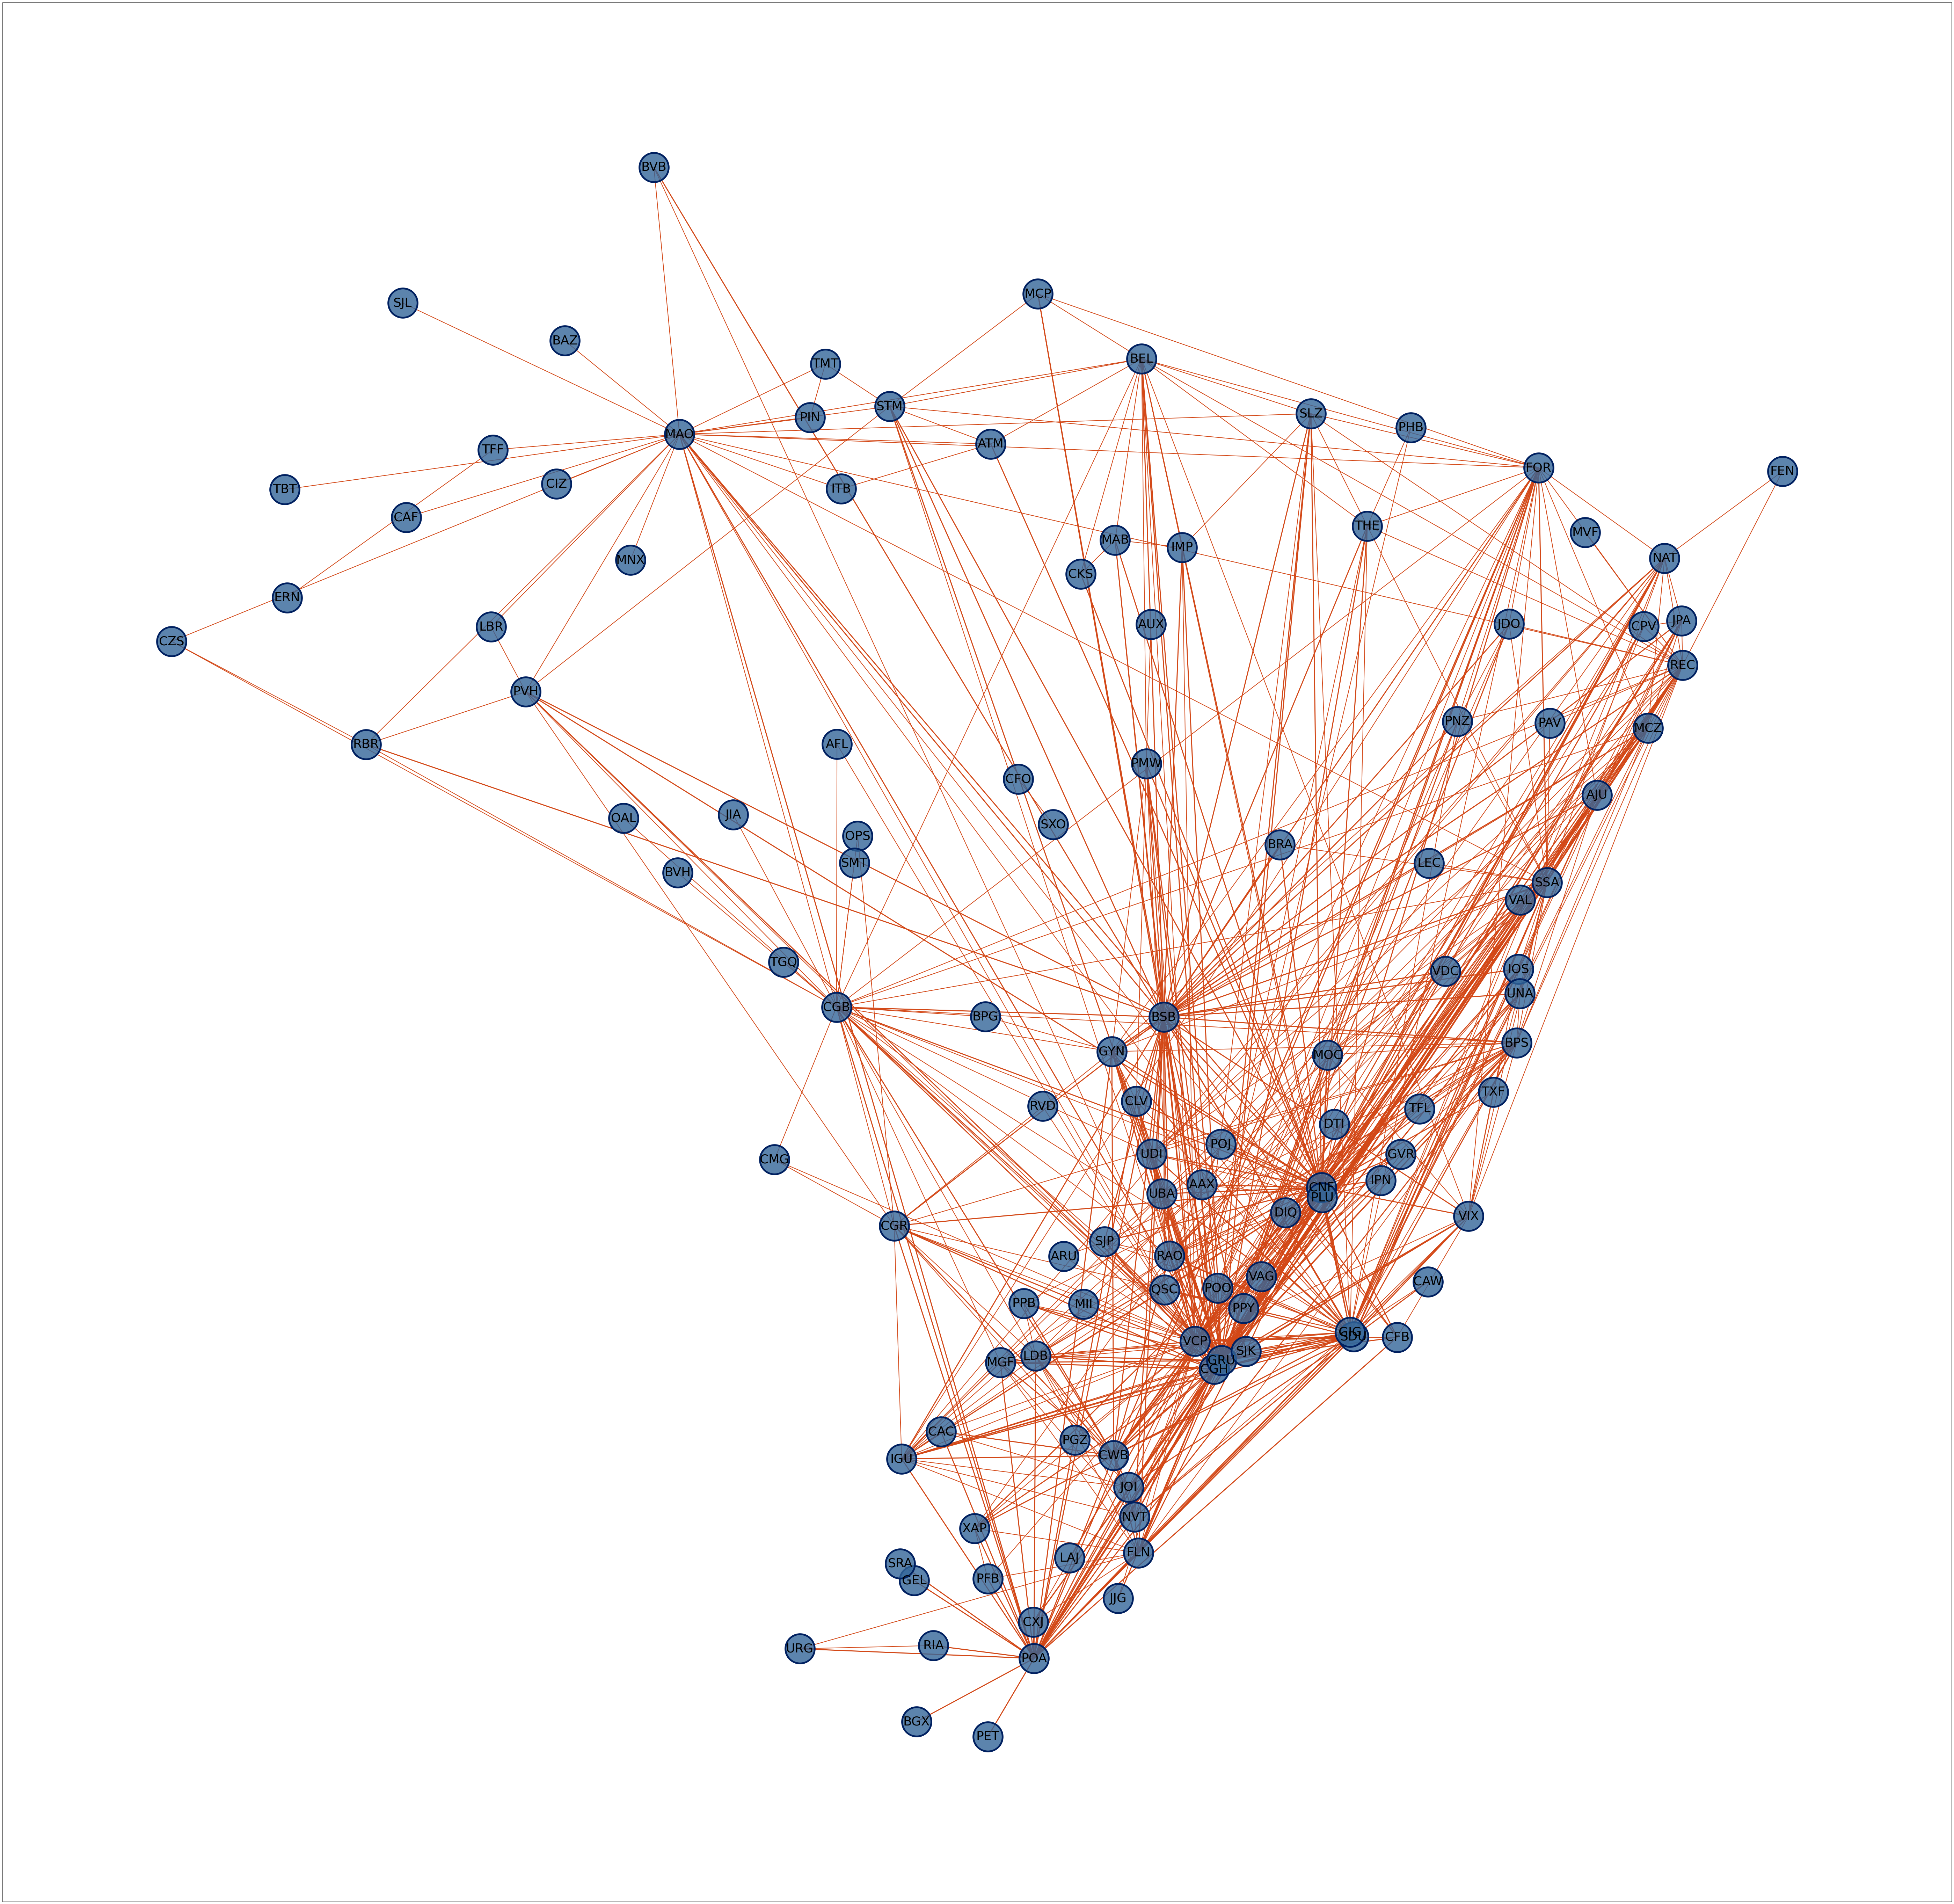

In [8]:

G = desenha_grafo2(2018, 'Map')


In [9]:
#Remoção dos 2 aeroportos problemáticos
G.remove_node('SXO')
G.remove_node('CFO')



**Qual aeroporto brasileiro voava, em 2018, para mais cidades distintas?**
Essa pergunta pode ser respondida utilizando o conceito de Grau ou Centralidade Por Grau, conforme Código abaixo. Com isso, podemos verificar que o aeroporto com voos para o maior número de cidades distintas é o VCP, com 67 voos, e com maior centralidade por grau.



In [10]:
#Centralidade por Grau
cent = nx.degree_centrality(G)
df_cent = pd.DataFrame(cent.items(), columns=['Airport', 'Degree Centrality'])
df_cent = df_cent.sort_values(by=['Degree Centrality'], ascending=False)
df_cent = df_cent.reset_index(drop=True)
print(df_cent.iloc[0])

#Cálculo de Grau por nó
grau = dict(G.degree)
df_grau = pd.DataFrame(grau.items(), columns=['Airport', 'Degree'])
df_grau = df_grau.sort_values(by=['Degree'], ascending=False)
df_grau = df_grau.reset_index(drop=True)
print('\n')
print(df_grau.iloc[0])



Airport                   VCP
Degree Centrality    0.582609
Name: 0, dtype: object


Airport    VCP
Degree      67
Name: 0, dtype: object


**Qual o grau médio, ou seja, número de outros aeroportos conectados, dos aeroportos brasileiros com voos em 2018?** Grau Médio = 10.


In [11]:
#Cálculo de Grau Médio
grau_medio = sum(df_grau['Degree']) / len(df_grau)
print('Grau Médio = ', "{:.0f}".format(grau_medio))


Grau Médio =  10


 **Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem?** O aeroporto que precisa de mais escalas para se conectar é o ERN, que se conecta com os aeroportos AUX, TFL, DTI, POO e PPY com uma distancia de 5.

In [12]:
#Cálculo do menor caminho para todas as combinações de nós, ignorando apenas a distância de um nó a ele mesmo
airports_br_list = G.nodes()
diam = nx.diameter(G)
diam_df = pd.DataFrame(columns=('Origin', 'Destination', 'Distance'))
i = 0
for airport_source in airports_br_list:
  for airport_target in airports_br_list:
      if airport_source != airport_target:
        distancia = nx.shortest_path_length(G, airport_source, airport_target)
        if distancia == diam:
          add = {'Origin': airport_source, 'Destination': airport_target, 'Distance': distancia}
          diam_df = diam_df.append(add, ignore_index=True)

#Remoção de cálculos de distância duplicados, visto que, para fins de cálculo, não há diferença de distância entre voos de ida ou volta, por exemplo: AUX -> ERN = ENR -> AUX.
diam_df['ref_o'] = diam_df[['Origin', 'Destination']].max(axis=1)
diam_df['ref_d'] = diam_df[['Origin', 'Destination']].min(axis=1)
diam_df = diam_df.drop_duplicates(subset=['ref_o', 'ref_d']).reset_index(drop=True)
diam_df = diam_df.drop(['ref_o', 'ref_d'], axis=1)
print(diam_df)


  Origin Destination Distance
0    AUX         ERN        5
1    TFL         ERN        5
2    DTI         ERN        5
3    ERN         POO        5
4    ERN         PPY        5
